# Nearest Neighbors

In [1]:
# WARNING: EXPENSIVE COMPUTING IF RUN_CALCULATION = True
# Calculation has already been done and saved in FILEPATH file and are reloaded from the file in this notebook
RUN_CALCULATION = False
GRID_FILEPATH   = 'saved_grid_search_results/knn_grid.npy'
MODEL_FILEPATH  = 'saved_best_models/knn_model.npy'

In [2]:
# Import functions used in the different notebooks of the course project
%run Tools.ipynb

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid, StratifiedKFold

import datetime

## Load & Split Train/Test Sets

In [4]:
# Load the overfeat dataset
overfeat, pixels, labels, names = load_data()

# Check shapes
print('Overfeat shape:', overfeat.shape)
print('Labels shape:', labels.shape)

Overfeat shape: (5000, 4096)
Labels shape: (5000,)


In [5]:
# Split the train/test sets (4000/1000 stratified split)
X_train, X_test, y_train, y_test = split_data_stratified(overfeat, labels)
print('Train shape:', X_train.shape, y_train.shape)
print('Test shape:', X_test.shape, y_test.shape)

# Check the classes distribution in the test set
print('\nTest Classes Distribution:')
pd.value_counts(names[y_test])

Train shape: (4000, 4096) (4000,)
Test shape: (1000, 4096) (1000,)

Test Classes Distribution:


car         250
airplane    250
truck       250
ship        250
dtype: int64

## Grid Search

K Nearest Neighbors models are very intuitive and good models to get some insight/baseline about the power of prediction of our futur models. kNN is great in the sense that it don't try to learn some coefficients and don't make any assumption about the linearity or non-linearity of the data. Data points are simply points in an N dimensional space with a target value. Features are only used to compute the distance between data points. The predicted target value of a test data point is attributed in function of its k nearest neighbors data point target values. So, there are in fact two functions behind the scene: 

* One function that computes the distance (L1, L2, or something else if we want)
* One function that returns a predicted target value from the target values of the k nearest data points (class with the most occurrence for example)

So, with grid search, we will tune the following hyperparameters:

* `k` that is the number of nearest neighbors. K have a direct impact on the bias/variance trade-off, low k values lead to highly flexible models with low bias but high variance and reciproquely, high k values lead to rigid model with high bias but low variance.
* `p` that is the way the distance is computed (L1 distance or euclidian L2 distance)
* `PCA n components` because we are also interested about the impact of reducing the number of dimension with PCA

In [6]:
# Hyperparameters
pca__n_components = [13, 62, 176, 408]  # variance about [50%, 80%, 90%, 95%]
knn__n_neighbors = np.arange(5, 101, 5)
knn__p = [1, 2]
    
# Grid search calculation if not already computed previously or forced
if RUN_CALCULATION | (os.path.exists(GRID_FILEPATH) == False):
    
    # Pipeline estimator
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=0)),
        ('knn', KNeighborsClassifier(algorithm='brute'))
    ])

    # Grid parameters
    grid = ParameterGrid(
        {
            'pca__n_components': pca__n_components,
            'knn__n_neighbors': knn__n_neighbors,
            'knn__p': knn__p,
        }
    )

    # Stratified K-Fold (3200 train/800 validation => 5 folds)
    skf = StratifiedKFold(n_splits=5, random_state=0)

    # Progress status variables
    n_steps = len(grid)
    i = 1

    # Grid Search
    scores = []
    for params_dict in grid:
    
        # print progress status
        print('{} | {}/{} | PCA {}, Neighbors {}, Distance {}'.format(
            datetime.datetime.now().time(),
            i, 
            n_steps,
            params_dict['pca__n_components'],
            params_dict['knn__n_neighbors'],
            params_dict['knn__p']
        ))
        i += 1
    
        # set hyperparameters
        pipe.set_params(**params_dict)
    
        # cross-validation
        train_accuracy = []
        validation_accuracy = []
        for idx_train, idx_valid in skf.split(X_train, y_train):
    
            # training set
            X = X_train[idx_train]
            y = y_train[idx_train]
        
            # validation set
            X_valid = X_train[idx_valid]
            y_valid = y_train[idx_valid]
        
            # fit model
            pipe.fit(X, y)
    
            # train accuracy
            train_accuracy.append(pipe.score(X, y))
    
            # validation accuracy
            validation_accuracy.append(pipe.score(X_valid, y_valid))
    
        # Compute the mean of the accuracies obtained on each fold
        params_dict['training_accuracy']   = np.mean(train_accuracy)
        params_dict['validation_accuracy'] = np.mean(validation_accuracy) 
    
        # save results with hyperparameters 
        scores.append(params_dict)
    
    # Save results in a numpy file
    np.save(GRID_FILEPATH, scores)
else:
    # Load the grid scores results from file
    scores = list(np.load(GRID_FILEPATH, allow_pickle=True))

In [7]:
# Create a DataFrame to analyze the grid search results
df = pd.DataFrame(scores)

# Show the hyperparameters for the best validation accuracy
df_best_scores = df.sort_values(by='validation_accuracy', ascending=False)
df_best_scores.head(20)

,knn__n_neighbors,knn__p,pca__n_components,training_accuracy,validation_accuracy
39,25,2,408,0.804250,0.78025
38,25,2,176,0.805188,0.77900
78,50,2,176,0.796375,0.77850
79,50,2,408,0.792687,0.77825
87,55,2,408,0.790438,0.77825
70,45,2,176,0.792688,0.77825
118,75,2,176,0.783625,0.77825
37,25,2,62,0.801375,0.77825
61,40,2,62,0.796625,0.77800
86,55,2,176,0.793188,0.77800


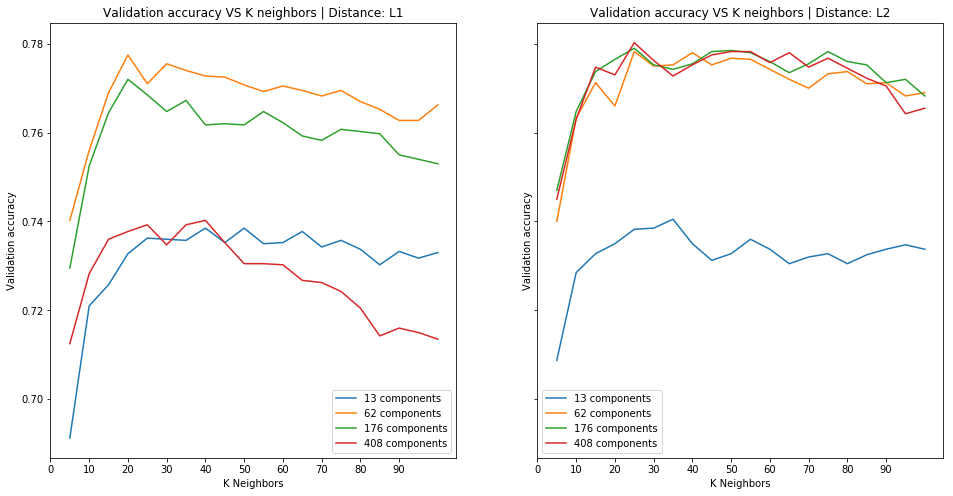

In [8]:
# Plot the validation accuracy vs neighbors curves for the different combinations of hyperparameters
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))

i = 0
for p in knn__p:
    for n_components in pca__n_components:
        filter = (df.pca__n_components == n_components) & (df.knn__p == p)
        ax[i].plot(df.knn__n_neighbors[filter], df.validation_accuracy[filter], label='{} components'.format(n_components))
        ax[i].set(xlabel='K Neighbors', 
                  ylabel='Validation accuracy',
                  title='Validation accuracy VS K neighbors | Distance: L{}'.format(p),
                  xticks=np.arange(0, 100, 10)
                 )
        ax[i].legend()
    i += 1

plt.show()

The best results is obtained with the L2 distance but dispite this fact, it appears that models built with the L1 distance are very sensitive to the number of pca components, so a supplementary optimal hyperparameter to find to expect good results. It maybe means that in our n dimensional space, there are a lot of small clusters near to each others. Because the L1 distance is always greater than the L2 distance (more pronounced with the increase of the number of dimensions), the L1 distance catch wrong clusters, so the decrease in the validation accuracy. Note that the probability to have clusters along dimension axis increase with the number of dimensions, theses clusters will be favored by the L1 distance, even if there are nearer clusters spreaded around the origin.

Concerning the models with the L2 distance, as soon as the number of pca components/variance explained is sufficient, the curves are very similiar and seems to agree that the number of neighbors to use is around 25.  

In [9]:
# Get hyperparameters for the best model
best_model = max(scores, key=lambda d: d['validation_accuracy'])

# Print the hyperparameters of the best model
print('Top accuracy on validation set: {:.3f} with number of component: {}, k: {}, distance metric: L{}'.format(
    best_model['validation_accuracy'],
    best_model['pca__n_components'],
    best_model['knn__n_neighbors'],
    best_model['knn__p']
))

Top accuracy on validation set: 0.780 with number of component: 408, k: 25, distance metric: L2


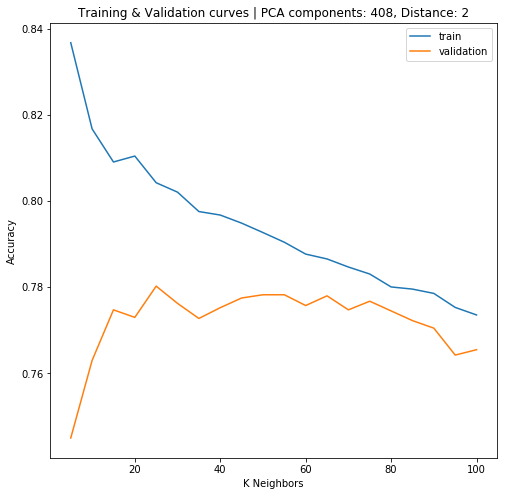

In [10]:
# Plot training & validation curves of the best model
filter = (df.pca__n_components == best_model['pca__n_components']) & (df.knn__p == best_model['knn__p'])

plt.figure(figsize=(8, 8))
plt.plot(df.knn__n_neighbors[filter], df.training_accuracy[filter], label='train')
plt.plot(df.knn__n_neighbors[filter], df.validation_accuracy[filter], label='validation')
plt.title('Training & Validation curves | PCA components: {}, Distance: {}'.format(
    best_model['pca__n_components'],
    best_model['knn__p']
))
plt.xlabel('K Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As expected, the training accuracy decrease as the model become less flexible (high k value) and the validation accuracy follow an inverted U shape with an optimum value around 25 neighbors.

# Accuracy on the test set

In [11]:
if RUN_CALCULATION | (os.path.exists(MODEL_FILEPATH) == False):
    
    # Pipeline estimator
    knn_model = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=best_model['pca__n_components'], random_state=0)),
        ('knn', KNeighborsClassifier(
            algorithm='brute',
            n_neighbors=best_model['knn__n_neighbors'],
            p=best_model['knn__p']
        ))
    ])

    # Fit model on the full train set
    knn_model.fit(X_train, y_train)
    
    # Save model
    np.save(MODEL_FILEPATH, knn_model)
else:
    # Load the grid scores results from file
    knn_model = np.load(MODEL_FILEPATH, allow_pickle=True).item(0)

# Evaluate accuracy on the test set
test_accuracy = knn_model.score(X_test, y_test)
print('k-NN accuracy (test set): {:.3f}'.format(test_accuracy))

k-NN accuracy (test set): 0.780


Exactly the same value as the validation accuracy by chance. In the mean time, it is the goal of cross validation to asses model performances and allow model selection.

# 4. The 10 nearest images

In [12]:
# Split pixel images into train/test set the same manner as the overfeat data
X_pix_train, X_pix_test, y_pix_train, y_pix_test = split_data_stratified(pixels, labels)

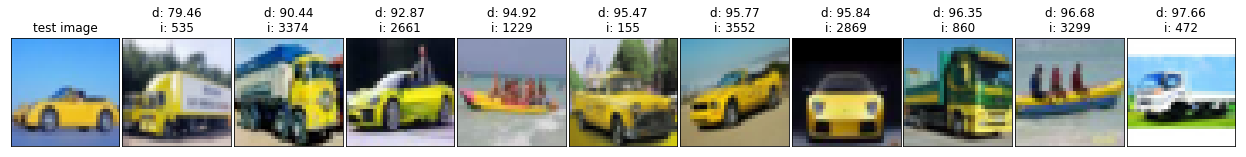

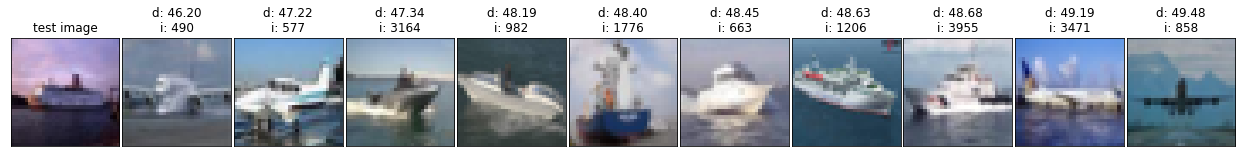

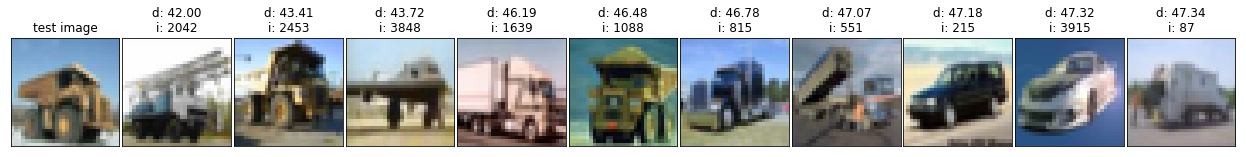

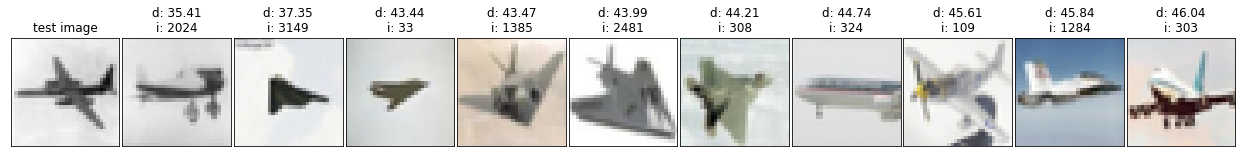

In [13]:
# Extract Scaler, PCA & KNeighborsClassifier from the pipeline
scaler = knn_model.named_steps['scaler']
pca = knn_model.named_steps['pca']
knn = knn_model.named_steps['knn']

# Index of test images
IDXs = [222, 444, 666, 999]

# For each test images:
for IDX in IDXs:
    
    # Get the test image and its overfeat representation
    img_pixels = X_pix_test[IDX, :]
    img_overfeat = X_test[IDX, :]

    # Rescale the overfeat representation of the test image
    img_overfeat_rescaled = scaler.transform(img_overfeat.reshape(1, len(img_overfeat)))

    # Apply PCA to the overfeat rescaled representation of the test image
    img_overfeat_pca = pca.transform(img_overfeat_rescaled)

    # Get the distance and indices of the 10 nearest neighbors 
    distances, indices = knn.kneighbors(img_overfeat_pca, n_neighbors=10, return_distance=True)

    # Plot the 10 nearest images with the test image from the test set
    images = X_pix_train[indices][0]
    fig, axes = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))

    # Plot images
    for i, ax in enumerate(axes.flatten()):
    
        if i == 0:
            img = img_pixels.reshape(32, 32, 3)
            ax.set_title('test image')
        else:
            img = images[i - 1].reshape(32, 32, 3)
            ax.set_title('d: {:.2f}\ni: {}'.format(distances[0, i-1], indices[0, i-1]))
    
        ax.imshow(img / 255)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
      
    plt.subplots_adjust(wspace=0, hspace=0)    
    plt.show()

Fun exercice and results overall. We have developped a model to classify 4 classes of images and in the same time find similar images with interesting results and understandable mistakes (not sure the guy who own the racing car would be happy to know that its car looks like a caterpillar truck but... it looks really big :)